# Extract GPS data from dashcam footage
gps_bend_finding_with_gaussian_smoothing_and_DBSCAN_clustering_and_circle_fitting

In [352]:
ids = [16]

min_string_length = 9
DATASET_PATH = "/home/aap9002/Stereo-Road-Curvature-Dashcam"
min_speed_filter = 5

In [353]:
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.cluster import DBSCAN

In [354]:
def count_frames(video_path:str):
    """Count the number of frames in the video

    Args:
        video_path (str): The path to the video

    Returns:
        int: The number of frames in the video
    """
    
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return length

def get_file_and_output_folder(id:int):
    """Get the file path and output folder for the given id

    Args:
        id (int): The id of the video

    Returns:
        tuple[str, str]: The file path and the output_folder
    """
    
    file_path = f"{DATASET_PATH}/day/{id:03d}/R.MP4"
    output_folder = f"{DATASET_PATH}/day/{id:03d}/bends"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File {file_path} not found')
    
    print(f'Processing video {id:03d} with {count_frames(file_path)} frames')
    os.makedirs(output_folder, exist_ok=True)
    print(f'Results will be saved in {output_folder}')
    return file_path, output_folder

def time_stamp_to_seconds(time_stamp:str):
    """Convert a time stamp to seconds

    Args:
        time_stamp (str): The time stamp in the format HHMMSS:sss

    Returns:
        int: The seconds since midnight
    """
    
    hours = int(time_stamp[:2])
    minutes = int(time_stamp[2:4])
    seconds = int(time_stamp[4:6])
    milliseconds = int(time_stamp[7:])

    return (hours*60*60 + minutes*60 + seconds)*1000 + milliseconds

# Lat and Long to X and Y

In [355]:
def lat_lon_to_x_y(lat:float, lon:float, height:float = 0):
    """Convert latitude, longitude and height to x, y and z

    Args:
        lat (float): latitude
        lon (float): longitude
        height (float): height above sea level
    """
    lat = np.radians(lat)
    lon = np.radians(lon)

    a = 6378137.0 # equatorial radius
    f = 0.003352810681183637418 # flattening

    e2 = f*(2-f) # first eccentricity squared

    Rn = a / np.sqrt(1 - e2*np.sin(lat)**2) # radius of curvature in the prime vertical

    lat = np.radians(lat)
    lon = np.radians(lon)

    # calculate x, y, z
    x = (Rn + height) * np.cos(lat) * np.cos(lon)
    y = (Rn + height) * np.cos(lat) * np.sin(lon)
    z = (Rn*(1-e2) + height) * np.sin(lat)

    return x, y, z

In [356]:
file_path, output_folder = get_file_and_output_folder(ids[0])

Processing video 016 with 5400 frames
Results will be saved in /home/aap9002/Stereo-Road-Curvature-Dashcam/day/016/bends


In [357]:
!firefox {file_path} # display the video

Gtk-Message: 01:41:11.508: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[201493, Main Thread] WARNING: GTK+ module /snap/firefox/5701/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:201

(firefox_firefox:201493): Gtk-WARNING **: 01:41:11.582: GTK+ module /snap/firefox/5701/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 01:41:11.582: Failed to load module "canberra-gtk-module"
[201493, Main Thread] WARNING: GTK+ module /snap/firefox/5701/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the s

# Read file contents

### NMEA string extraction

In [358]:
def getNMEAStringsFromFile(file_path:str):
    """Get the NMEA strings from the file

    Args:
        file_path (str): The path to the file

    Returns:
        List[str]: The GPRMC|GPGGA strings from the file
    """
    strings = ""
    with open(file_path, "rb") as f:
        strings = f.read()

    pattern =  rb'\$(?:GPRMC|GPGGA)[ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

Get the NMEA strings from the video file.

In [359]:
data = getNMEAStringsFromFile(file_path)
frame_count = count_frames(file_path)
print(f'Found {len(data)} GPS records, of which {frame_count} frames are available')
data[:10]

Found 3984 GPS records, of which 5400 frames are available


['$GPRMC,161800.000,A,5305.89530,N,00226.21048,W,9.115,110.28,151124,,,A*55',
 '$GPGGA,161800.000,5305.89530,N,00226.21048,W,1,08,1.52,50.6,M,49.8,M,,*5B',
 '$GPRMC,161800.100,A,5305.89524,N,00226.21007,W,9.179,103.73,151124,,,A*5C',
 '$GPGGA,161800.100,5305.89524,N,00226.21007,W,1,08,1.52,50.6,M,49.8,M,,*54',
 '$GPRMC,161800.200,A,5305.89520,N,00226.20965,W,9.273,97.88,151124,,,A*66',
 '$GPGGA,161800.200,5305.89520,N,00226.20965,W,1,08,1.52,50.5,M,49.8,M,,*5C',
 '$GPRMC,161800.300,A,5305.89513,N,00226.20925,W,9.034,102.50,151124,,,A*5A',
 '$GPGGA,161800.300,5305.89513,N,00226.20925,W,1,08,1.52,50.5,M,49.8,M,,*59',
 '$GPRMC,161800.400,A,5305.89508,N,00226.20882,W,9.279,101.35,151124,,,A*50',
 '$GPGGA,161800.400,5305.89508,N,00226.20882,W,1,08,1.52,50.5,M,49.8,M,,*58']

NMEA string parsing and data extraction

In [360]:
def knots_to_mph(knots:float):
    """Convert knots to miles per hour

    Args:
        knots (float): The speed in knots

    Returns:
        float: The speed in miles per hour
    """
    return knots * 1.15078

def parse_gprmc(input_sequence:str):
    """Parse the GPRMC and GPGGA string and extract the latitude, longitude, height and speed

    Args:
        input_sequence (str[]): [GPRMC string, GPGGA string]

    Returns:
        dict: The extracted values as a dictionary
    """
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts_GPRMC = input_sequence[0].split(',')
    if len(parts_GPRMC) < 10 or parts_GPRMC[0] != '$GPRMC':
        # print(f'Invalid GPRMC string: {input_sequence}')
        return None
    
    # $GPGGA,<time>,<latitude>,<N/S>,<longitude>,<E/W>,<quality>,<satellites>,<HDOP>,<height>,<height unit>,<geoid separation>,<geoid separation unit>,<age of differential data>,<station ID>,<checksum>
    parts_GPGGA = input_sequence[1].split(',')
    if len(parts_GPGGA) < 10 or parts_GPGGA[0] != '$GPGGA':
        # print(f'Invalid GPGGA string: {input_sequence}')
        return None

    
    # Extract latitude and longitude with direction
    time = parts_GPRMC[1]
    valid = parts_GPRMC[2]  # A - data valid, V - data invalid
    latitude = parts_GPRMC[3]
    lat_direction = parts_GPRMC[4]
    longitude = parts_GPRMC[5]
    lon_direction = parts_GPRMC[6]
    height = parts_GPGGA[9]  # Height above sea level
    speed = parts_GPRMC[7]  # Speed in knots

    if valid == 'A': # check if the data record is valid
        speed = knots_to_mph(float(speed))  # Convert speed to mph
        
    # Return the extracted values as a dictionary
    return {
        "time": time,
        "valid": True if valid == 'A' else False,
        "latitude": latitude + ' ' + lat_direction,
        "longitude": longitude + ' ' + lon_direction,
        "height": height,
        "speed": speed
    }

In [361]:
# parse gps records at a step of two to capture both GPRMC and GPGGA records
positions = []
for i in range(0, len(data), 2):
    lat_lon = parse_gprmc(data[i:i+2])
    if lat_lon:
        positions.append(lat_lon)

# status of the records
print(f"Found {len(positions)} positions")
print("valid positions:", len([p for p in positions if p['valid']]))
print("invalid positions:", len([p for p in positions if not p['valid']]))

# remove records with the same values
positions = [dict(t) for t in {tuple(d.items()) for d in positions}]
print(f"Unique positions: {len(positions)}")

Found 1992 positions
valid positions: 1992
invalid positions: 0
Unique positions: 1811


### Video Metadata extraction

In [362]:
cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f"Total frames: {total_frames}")

print(f"Frame rate: {frame_rate}")

Total frames: 5400
Frame rate: 29.97002997002997


Get the start and end frame time to be used to predict frame number based on time stamp offset

In [363]:
# Get start and end time for frame estimation
positions = sorted(positions, key=lambda x: x['time'])
STARTING_TIME = time_stamp_to_seconds(positions[0]['time'])
print(f"Starting time: {STARTING_TIME}")

END_TIME = time_stamp_to_seconds(positions[-1]['time'])
print(f"Ending time: {END_TIME}")

positions[1]
positions[-5]

Starting time: 17203100
Ending time: 58860000


{'time': '162059.600',
 'valid': True,
 'latitude': '5305.86186 N',
 'longitude': '00225.75715 W',
 'height': '49.4',
 'speed': 0.51324788}

<!-- ### GPS Position valid filtering -->

In [364]:
# filter out invalid GPS records
positions = [p for p in positions if p['valid']]
print(f"Valid positions: {len(positions)}")
print(f"Invalid positions: {len(positions)}")

positions[:2]

Valid positions: 1811
Invalid positions: 1811


[{'time': '044643.100',
  'valid': True,
  'latitude': '5321.80868 N',
  'longitude': '00216.22259 W',
  'height': '79.9',
  'speed': 15.999294339999999},
 {'time': '044643.200',
  'valid': True,
  'latitude': '5321.80828 N',
  'longitude': '00216.22253 W',
  'height': '80.0',
  'speed': 16.44004308}]

### Convert Lat Lon to X, Y
Convert to a 2D plane to convert out gps points to a meter based X, Y coordinate system
- improves relative distance calculation accuracy
- creates a relative scale between lon and lat
- improves clustering accuracy
- improves circle fitting accuracy

In [365]:
# process the positions to get x, y, z
for position in positions:
    lat, lon = position['latitude'], position['longitude']
    lat = float(lat.split()[0])
    lon = float(lon.split()[0])
    h = float(position['height'])
    position['x'], position['y'], position['z'] = lat_lon_to_x_y(lat, lon, h)


Original_Positions = positions.copy()
positions[:2]

[{'time': '044643.100',
  'valid': True,
  'latitude': '5321.80868 N',
  'longitude': '00216.22259 W',
  'height': '79.9',
  'speed': 15.999294339999999,
  'x': np.float64(-321147.94163587206),
  'y': np.float64(-21183.104144028955),
  'z': np.float64(6347890.3032363765)},
 {'time': '044643.200',
  'valid': True,
  'latitude': '5321.80828 N',
  'longitude': '00216.22253 W',
  'height': '80.0',
  'speed': 16.44004308,
  'x': np.float64(-321147.17307225976),
  'y': np.float64(-21183.047553969238),
  'z': np.float64(6347890.501872528)}]

# Plot GPS positions on graph

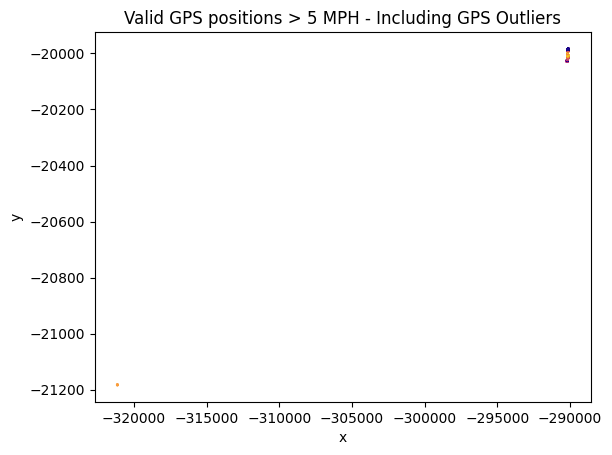

In [366]:
x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma


plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH - Including GPS Outliers')
plt.show()

### Remove outliers from our data

Median x: -290151.9119857961
Median y: -19991.031260501022


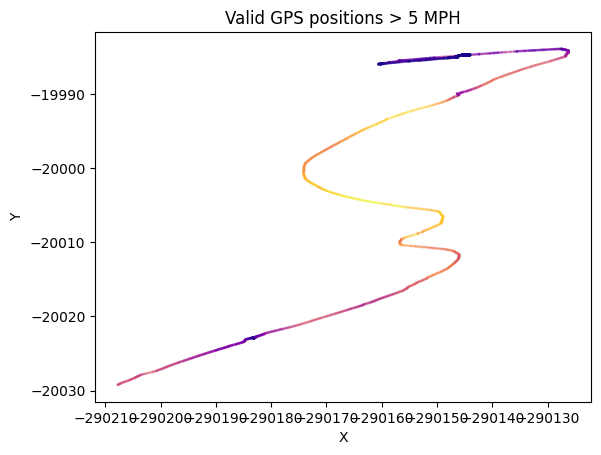

In [367]:
MIN_DISTANCE_OUTLIER_FILTER = 1000 # 1KM distance from the median

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

# calculate the median x and y
median_x = np.median(x)
median_y = np.median(y)
print(f'Median x: {median_x}')
print(f'Median y: {median_y}')

# filter out the points that are not within the MIN_DISTANCE_OUTLIER_FILTER
positions = [
    pos for pos in positions
        if abs(pos['x'] - median_x) < MIN_DISTANCE_OUTLIER_FILTER and 
            abs(pos['y'] - median_y) < MIN_DISTANCE_OUTLIER_FILTER
        ]

# plot the filtered points
x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]
speeds = [pos['speed'] for pos in positions]

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH')
plt.show()

In [368]:
# Get start and end time for frame estimation
positions = sorted(positions, key=lambda x: x['time'])
STARTING_TIME = time_stamp_to_seconds(positions[0]['time'])
print(f"Starting time: {STARTING_TIME}")

END_TIME = time_stamp_to_seconds(positions[-1]['time'])
print(f"Ending time: {END_TIME}")

positions[1]
positions[-5]

Starting time: 58680000
Ending time: 58860000


{'time': '162059.600',
 'valid': True,
 'latitude': '5305.86186 N',
 'longitude': '00225.75715 W',
 'height': '49.4',
 'speed': 0.51324788,
 'x': np.float64(-290145.40756765095),
 'y': np.float64(-19984.686314808063),
 'z': np.float64(6350122.431520528)}

### Remove invalid records and records under min_speed_filter mph

In [369]:
def filter_invalid_and_low_mph_records(positions):
    """Filter the data points to remove
        - invalid points
        - points less than min_speed_filter mph
        - points with the same latitude and longitude
    
    Args:
        positions (List[dict]): The list of positions
    
    Returns:
        List[dict]: The filtered list of positions
    """
    
    filtered_positions = []
    for i in range(len(positions)):
        if not positions[i]['valid']:
            continue

        if positions[i]['speed'] < min_speed_filter:
            continue

        filtered_positions.append(positions[i])
    return filtered_positions

In [370]:
positions = filter_invalid_and_low_mph_records(positions)
positions = sorted(positions, key=lambda x: x['time']) # sort by time

print(f"{len(positions)} positions after filtering")
positions[:2]

961 positions after filtering


[{'time': '161800.000',
  'valid': True,
  'latitude': '5305.89530 N',
  'longitude': '00226.21048 W',
  'height': '50.6',
  'speed': 10.4893597,
  'x': np.float64(-290207.7476241849),
  'y': np.float64(-20029.246124047266),
  'z': np.float64(6350122.477680791)},
 {'time': '161800.100',
  'valid': True,
  'latitude': '5305.89524 N',
  'longitude': '00226.21007 W',
  'height': '50.6',
  'speed': 10.563009619999999,
  'x': np.float64(-290207.63341309945),
  'y': np.float64(-20029.201823959713),
  'z': np.float64(6350122.479762363)}]

# Find closest position entry to point of interest

In [371]:
def get_points_near_a_cluster_estimated_center(
        cluster_center:list[float],
        positions:list[dict],
        distance_threshold:float = 100):
    """Get the points near a cluster estimated center

    Args:
        cluster_center (list[float]): list of estimated centers
        positions (list[dict]): list of gps positions
        distance_threshold (float, optional): The distance threshold. Defaults to 100.

    Returns:
        list[dict]: The positions within the distance threshold
    """
    points = []
    for position in positions:
        x = float(position['y'])
        y = float(position['x'])
        distance = np.sqrt((x - cluster_center[1])**2 + (y - cluster_center[0])**2)
        if distance < distance_threshold:
            points.append(position)
    return points

# Find bends

In [372]:
def apply_median_filter(records:list[float], size:int = 5):
    """Apply a median filter to a list

    Args:
        records (list[float]): The list of points
        size (int, optional): Kernel size. Defaults to 5.

    Returns:
        list[float]: The filtered points
    """

    temp = records.copy() # create a copy to avoid modifying the original list
    # slide a window of size 2*size+1 over the records
    for i in range(size, len(records)-size):
        temp[i] = np.median(records[i-size:i+size])
    return temp

In [373]:
def get_smoothed_sequence_angles(x_pos:list[float], y_pos:list[float]):
    """Get the smoothed sequence angles from x and y positions sequence

    Args:
        x_pos (list[float]): x positions
        y_pos (list[float]): y positions

    Returns:
        list[float]: The smoothed sequence angles
    """
    x_pos = apply_median_filter(x_pos, 3)
    y_pos = apply_median_filter(y_pos, 3)

    diff_x = np.diff(x_pos)
    diff_y = np.diff(y_pos)

    angles = np.arctan2(diff_x, diff_y)
    angles = np.arctan2(np.sin(angles), np.cos(angles)) # normalize angles
    angles = np.degrees(angles)

    # apply median filter
    angles = apply_median_filter(angles, 5)

    angles= np.diff(angles)

    # smooth angles with gaussian filter
    angles = np.convolve(angles, np.ones(3) / 3, mode='valid')
    gaussian_kernel = np.exp(-np.linspace(-1, 1, 3)**2)

    # zero first half of the kernel
    # zero = np.zeros_like(gaussian_kernel)
    # gaussian_kernel = np.concatenate([zero, gaussian_kernel])
    gaussian_kernel /= gaussian_kernel.sum()
    angles = np.convolve(angles, gaussian_kernel, mode='valid')

    return angles

### Config parameters for bend ROI findings

In [374]:
lower_threshold = 0.06  # degrees
DB_SCAN_EPS = 5
DB_SCAN_MIN_SAMPLES = 3

Found 955 angles
[1.51414014 0.84517398 0.93514233 0.99192906 0.7139962 ]


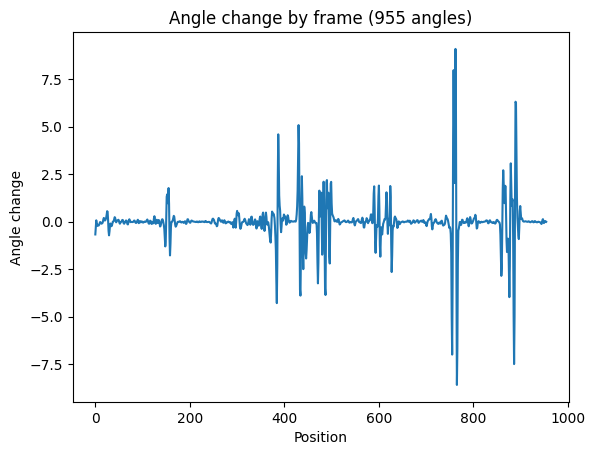

Found 561 bends
[-0.66896615 -0.2894989   0.07337754 -0.11057306 -0.21670727]
Found 4 bends after clustering


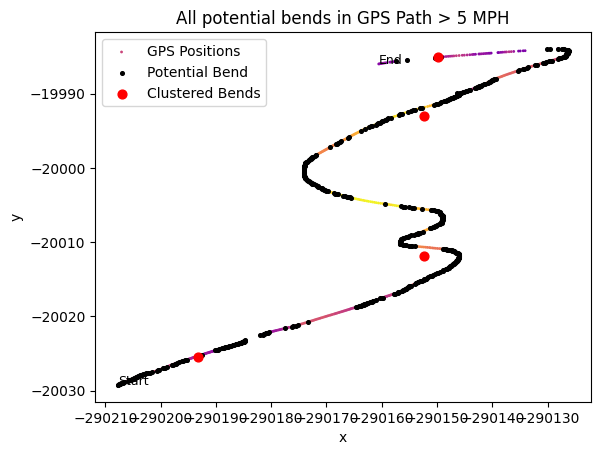

In [375]:
positions_ordered_by_time = sorted(positions, key=lambda x: time_stamp_to_seconds(x['time']))

x_pos = [pos['x'] for pos in positions_ordered_by_time]
y_pos = [pos['y'] for pos in positions_ordered_by_time]
speeds = [pos['speed'] for pos in positions_ordered_by_time]

angles = get_smoothed_sequence_angles(x_pos, y_pos)

print(f"Found {len(angles)} angles")
print(angles[:5])

angles_derivative = np.gradient(angles) # get the first derivative of the angles

plot_angles = angles_derivative
plt.title(f"Angle change by frame ({len(angles)} angles)")
plt.xlabel("Position")
plt.ylabel("Angle change")
plt.plot(plot_angles)
plt.show()

# bends above the threshold
bends = np.where(np.abs(angles_derivative) > lower_threshold)[0]

print(f"Found {len(bends)} bends")
print(angles_derivative[bends][:5])

# cluster bends
bends_positions = np.array(list(zip(x_pos, y_pos)))[bends]

temp_store_bends = bends_positions.copy() # Store the potential bends for plotting later

# bends = cluster.vq.kmeans(bends_positions, )[0] # not applicable since we need to know K
# Apply DBSCAN clustering (automatic K)
if len(bends_positions) > 1:
    dbscan = DBSCAN(eps=DB_SCAN_EPS, min_samples=DB_SCAN_MIN_SAMPLES, metric="euclidean")  # Adjust eps based on your GPS resolution
    labels = dbscan.fit_predict(bends_positions)
    
    # Get unique cluster centers
    unique_labels = set(labels)
    cluster_centers = np.array([bends_positions[labels == i].mean(axis=0) for i in unique_labels if i != -1])  # Ignore noise
else:
    cluster_centers = bends_positions  # If no clustering is needed, keep original bends

print(f"Found {len(cluster_centers)} bends after clustering")

plt.scatter(
    x_pos,
    y_pos,
    c=[cmap(norm(float(s))) for s in speeds],
    s=1,
    label='GPS Positions'
)

# add start and end points TEXT LABEL
plt.text(
    x_pos[0],
    y_pos[0],
    'Start',
    fontsize=9,
    color='black'
)

plt.text(
    x_pos[-1],
    y_pos[-1],
    'End',
    fontsize=9,
    color='black'
)

plt.scatter(
    temp_store_bends[:, 0],
    temp_store_bends[:, 1],
    color='black',
    label='Potential Bend',
    s=7
)

if len(cluster_centers) > 0:
    plt.scatter(
        cluster_centers[:,0],
        cluster_centers[:,1],
        color='red',
        label='Clustered Bends',
        s=40
    )
else:
    plt.legend(["GPS Positions", "Potential Bend"])
    
plt.title(f"All potential bends in GPS Path > {min_speed_filter} MPH")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
# plt.axis('equal')


plt.savefig(os.path.join(output_folder, "bends.png"))
plt.show()

In [376]:
print(f"total of {len(cluster_centers)} potential bend clusters found")
cluster_centers

total of 4 potential bend clusters found


array([[-290193.31312769,  -20025.45953281],
       [-290152.29038746,  -20011.80913186],
       [-290152.26562425,  -19993.01524138],
       [-290149.81859578,  -19985.07983042]])

### Estimate relevant frames

In [377]:
def time_stamp_to_frame_number(time_stamp:str, STARTING_TIME:int = STARTING_TIME, END_TIME:int = END_TIME, total_frames:int = total_frames):
    """Estimate frame number using the timestamp

    Args:
        time_stamp (str): The time stamp to convert
        STARTING_TIME (int, optional): video starting time stamp. Defaults to STARTING_TIME.
        END_TIME (int, optional): video ending timestamp. Defaults to END_TIME.
        total_frames (int, optional): total number of frames. Defaults to total_frames.

    Returns:
        int: frame number
    """
    # calculate the difference between the time stamp and the starting time
    diff = time_stamp_to_seconds(time_stamp) - STARTING_TIME

    total_time = END_TIME - STARTING_TIME

    # print(f"diff: {diff}, toal_time: {total_time}")

    if total_time <= 0:
        return 0
    
    # estimate the frame number
    predict_frame_number = int((diff / total_time) * total_frames)
    
    return predict_frame_number

def get_closest_position_based_on_lat_lon(x:float, y:float, positions:list[dict]):
    """Get the closest position based on x and y

    Args:
        lat (float): x
        lon (float): y
        positions (list[dict], optional): list of all positions. Defaults to positions.

    Returns:
        dict: The closest position
    """
    min_distance = float('inf')
    closest_position = None

    # print(positions[:5])

    for position in positions:
        p_x = position['x']
        p_y = position['y']
        distance = np.sqrt((p_x - x)**2 + (p_y - y)**2)

        if distance < min_distance:
            min_distance = distance
            closest_position = position

    return closest_position


def get_frame_number_based_on_bend_x_y(cluster_centers:list[list[float]], positions:list[dict] = positions):
    """Get the frame number based on the bend x and y for each cluster center

    Args:
        cluster_centers (list[list[float]]): list of cluster centers
        positions (list[dict], optional): list of considered positions. Defaults to positions.

    Returns:
        list[int]: list of frame numbers
    """
    frame_numbers = []
    for bend in cluster_centers:
        closest_position = get_closest_position_based_on_lat_lon(bend[0], bend[1], positions)
        frame_number = time_stamp_to_frame_number(closest_position['time'])
        # print(f"frame_number: {frame_number}")
        frame_numbers.append(frame_number)

    return frame_numbers

In [378]:
frame_numbers = get_frame_number_based_on_bend_x_y(cluster_centers)

print(f"Estimated frame numbers: {frame_numbers}")

Estimated frame numbers: [258, 1719, 2652, 3441]


### Output images of estimated frames

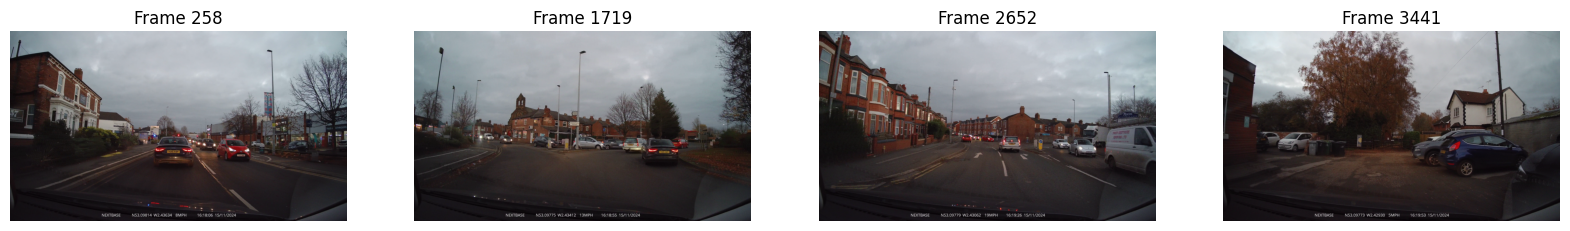

Total frames: 5400


In [379]:
frames = []

frame_numbers = sorted(frame_numbers)

for frame_number in frame_numbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        print(f"Warning: Could not read frame {frame_number}")
 
cap.release()

if frames:
    fig, axes = plt.subplots(1, len(frames), figsize=(20, 10))
    if len(frames) == 1:
        axes.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
        axes.axis('off')
        axes.set_title(f"Frame {frame_numbers[0]}")
    else:
        for i, frame in enumerate(frames):
            axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
            axes[i].set_title(f"Frame {frame_numbers[i]}")
    plt.show()
else:
    print("No frames to display")

print(f"Total frames: {total_frames}")

In [380]:
for i, frame in enumerate(frames):
    output_file = os.path.join(output_folder, f"bend_{i}.jpg")
    cv2.imwrite(output_file, frame)


# Calculate Bends in ROI

In [381]:
def plot_bend(bend_name:str, cluster_center:list[float], points:list[dict], focused_positions:list[dict]=None):
    """Plot the bend with the given name and points

    Args:
        bend_name (str): plot title
        points (list[dict]): list of points
    """
    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    x = [float(pos['x']) for pos in points]
    y = [float(pos['y']) for pos in points]
    
    plt.scatter(x, y, s=1)
    plt.scatter(cluster_center[0], cluster_center[1], color='red', s=40)
    if not focused_positions is None:
        focused_x = [float(pos['x']) for pos in focused_positions]
        focused_y = [float(pos['y']) for pos in focused_positions]
        plt.scatter(focused_x, focused_y, color='green', s=40)

    plt.text(
        x[0],
        y[0],
        'Segment Start',
        fontsize=9,
        color='black'
    )

    plt.text(
        x[-1],
        y[-1],
        'Segment End',
        fontsize=9,
        color='black'
    )

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'GPS positions near {bend_name}')
    plt.show()

find first curve of a series of points

In [382]:
def find_first_bend_from_series(points:list[dict], min_degree_threshold:float = 0.2):
    """Find the initial bend from the series of points

    Args:
        points (list[dict]): list of points

    Returns:
        list[float]: The initial bend
    """
    x = [pos['x'] for pos in points]
    y = [pos['y'] for pos in points]

    # x = np.convolve(x, np.ones(3) /3, mode='valid')
    # y = np.convolve(y, np.ones(3) / 3, mode='valid')

    angles = get_smoothed_sequence_angles(x, y)

    print(angles[:5])

    first_bend_found = False
    first_bend_sign = None

    tolerance = 10

    first_bend_positions = []
    for i in range(len(angles)):
        sign = np.sign(angles[i])
        if abs(angles[i]) > min_degree_threshold:
            if not first_bend_found:
                first_bend_positions.append(points[i])
                first_bend_found = True
                first_bend_sign = sign
            elif first_bend_sign == sign:
                first_bend_positions.append(points[i])
        if first_bend_found and sign != first_bend_sign:
            if tolerance <= 0:
                break
            tolerance -= 1

    if not first_bend_found:
        print("No first bend found")
        return None

    # determine if the first bend is a left or right bend
    if first_bend_sign < 0:
        print("First bend is a left bend")
    else:
        print("First bend is a right bend")

    return first_bend_positions

Bend 0: 109 points near the center - Avg Speed: 7.620612966605504
[ 0.24342629  1.81180676  1.02170779 -0.24800507 -0.25898938]
First bend is a right bend


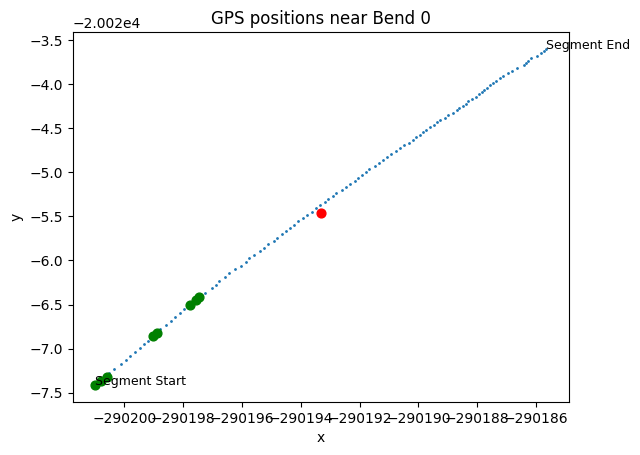

Bend 1: 235 points near the center - Avg Speed: 14.832530740340424
[-0.10826536  0.11799677 -0.02437987 -0.32746064 -0.30423403]
First bend is a left bend


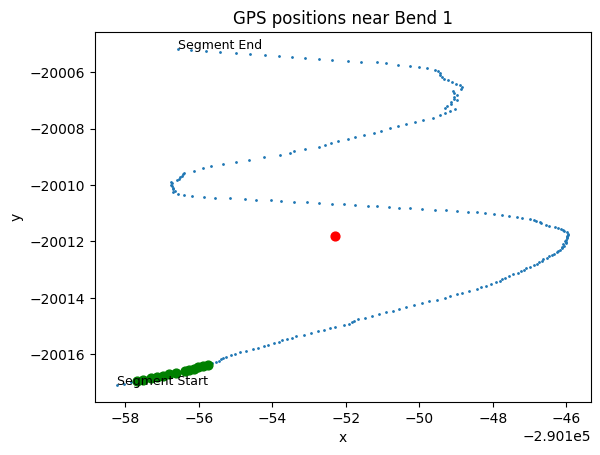

Bend 2: 67 points near the center - Avg Speed: 13.933249196119403
[-0.49788568  0.07264826  1.00645733  1.55544304  1.18661657]
First bend is a left bend


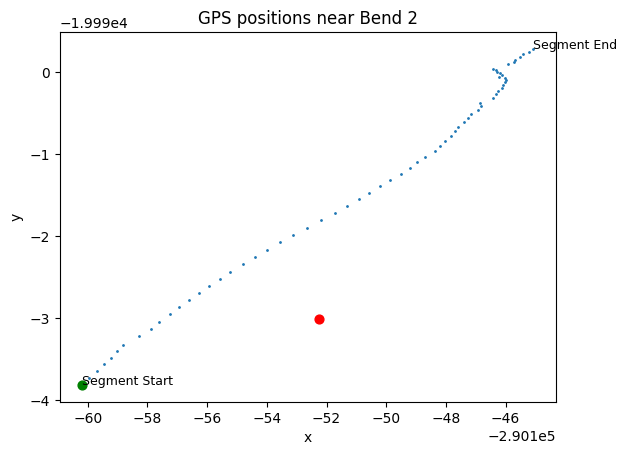

Bend 3: 87 points near the center - Avg Speed: 9.922078069425286
[ 0.0083962  -0.2979442  -0.44159519 -0.37674088 -0.26305811]
First bend is a left bend


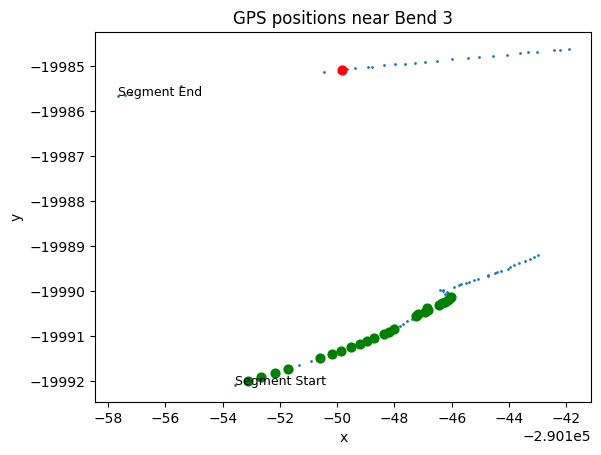

In [383]:
bends_for_curve_fitting = []

for i, bend in enumerate(cluster_centers):
    records = get_points_near_a_cluster_estimated_center(bend, positions, distance_threshold=8)
    print(f"Bend {i}: {len(records)} points near the center - Avg Speed: {np.mean([float(pos['speed']) for pos in records])}")
    focused_points = find_first_bend_from_series(records)
    plot_bend(f"Bend {i}", bend, records, focused_points)

    if len(records) > 0:
        bends_for_curve_fitting.append({
            "bend": bend,
            "points": records
        })

# Kasa Iterative Curve Fitting

In [384]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import least_squares

# class Circle:
#     def __init__(self, a, b, r, s, j):
#         self.a = a  # X-coordinate of the center
#         self.b = b  # Y-coordinate of the center
#         self.r = r  # Radius
#         self.s = s  # Root mean square error
#         self.j = j  # Total number of iterations

# class Data:
#     def __init__(self, X, Y):
#         self.X = np.array(X)
#         self.Y = np.array(Y)
#         self.n = len(X)

# def geometric_distance(params, X, Y):
#     a, b, r = params
#     return np.sqrt((X - a)**2 + (Y - b)**2) - r

# def Sigma(data, circle):
#     # Compute the root mean square error (estimate of sigma)
#     distances = np.sqrt((data.X - circle.a)**2 + (data.Y - circle.b)**2)
#     sigma = np.sqrt(np.mean((distances - circle.r)**2))
#     return sigma

# def CircleFitIterative(data, initial_guess=None, max_iterations=100, tol=1e-9):
#     if initial_guess is None:
#         # Use the Kasa method to obtain an initial guess
#         initial_guess = CircleFitByKasa(data)
#         initial_params = [initial_guess.a, initial_guess.b, initial_guess.r]
#     else:
#         initial_params = initial_guess

#     # Perform the iterative fitting using Levenberg–Marquardt algorithm
#     result = least_squares(geometric_distance, initial_params, args=(data.X, data.Y), max_nfev=max_iterations, ftol=tol, xtol=tol, gtol=tol)

#     # Extract the optimized parameters
#     a, b, r = result.x
#     s = Sigma(data, Circle(a, b, r, 0, 0))
#     j = result.nfev  # Number of function evaluations

#     return Circle(a, b, r, s, j)

# def CircleFitByKasa(data):
#     # Center the data points
#     Xi = data.X - np.mean(data.X)
#     Yi = data.Y - np.mean(data.Y)
#     Zi = Xi**2 + Yi**2

#     # Compute moments
#     Mxx = np.mean(Xi**2)
#     Myy = np.mean(Yi**2)
#     Mxy = np.mean(Xi * Yi)
#     Mxz = np.mean(Xi * Zi)
#     Myz = np.mean(Yi * Zi)

#     # Solve the system of equations using Cholesky factorization
#     G11 = np.sqrt(Mxx)
#     G12 = Mxy / G11
#     G22 = np.sqrt(Myy - G12**2)

#     D1 = Mxz / G11
#     D2 = (Myz - D1 * G12) / G22

#     # Compute parameters of the fitting circle
#     C = D2 / G22 / 2
#     B = (D1 - G12 * C) / G11 / 2

#     # Assemble the output
#     a = B + np.mean(data.X)
#     b = C + np.mean(data.Y)
#     r = np.sqrt(B**2 + C**2 + Mxx + Myy)
#     s = Sigma(data, Circle(a, b, r, 0, 0))
#     j = 0  # Number of iterations (not applicable for Kasa's method)

#     return Circle(a, b, r, s, j)

# f_bend = bends_for_curve_fitting[1]['points']
# order_by_time = sorted(f_bend, key=lambda x: time_stamp_to_seconds(x['time']))
# X = [float(pos['x']) for pos in order_by_time]
# Y = [float(pos['y']) for pos in order_by_time]

# diff_x = np.diff(X)
# diff_y = np.diff(Y)
# angles = np.arctan2(diff_x, diff_y)
# angles = np.arctan2(np.sin(angles), np.cos(angles)) # normalize angles
# angles = np.degrees(angles)

# angles = np.diff(angles)

# # smooth angles with gaussian filter
# angles = np.convolve(angles, np.ones(3) / 3, mode='same')


# # apply median filter
# angles = apply_median_filter(angles, 10)

# # plot angles
# plt.plot(angles)
# plt.show()

# min_degree = 0.5

# print(f"Found {len(X)} points before filtering")
# print(angles[:10])

# angle_threshold_mask = [np.abs(angles) > min_degree]
# print(angle_threshold_mask[:10])

# X_a = np.array(X[1:-1])[np.abs(angles) > min_degree]
# Y_a = np.array(Y[1:-1])[np.abs(angles) > min_degree]

# # # ignore after sign change
# # angles_temp = angles[np.abs(angles) > min_degree]
# # angle_sign = np.sign(angles_temp)
# # initial_angle = angle_sign[1]

# # X_a = []
# # Y_a = []

# # for i in range(1, min(len(X)-1, len(angles))):
# #     if np.abs(angles[i-1]) > min_degree:
# #         if not (angle_sign[i-1] != initial_angle):
# #             break
# #         X_a.append(X[i])
# #         Y_a.append(Y[i])


# print(f"Found {len(X_a)} points after filtering")

# data = Data(X_a,Y_a)
# fitted_circle = CircleFitIterative(data)


# print(f"Center: ({fitted_circle.a}, {fitted_circle.b})")
# print(f"Radius: {fitted_circle.r}")
# print(f"RMS Error: {fitted_circle.s}")
# print(f"Iterations: {fitted_circle.j}")

# plt.scatter(X, Y)
# plt.scatter(fitted_circle.a, fitted_circle.b, color='red')
# plt.scatter(X_a, Y_a, color='green')
# plt.text(
#     X[0],
#     Y[0],
#     'Segment Start',
#     fontsize=9,
#     color='black'
# )

# plt.text(
#     X[-1],
#     Y[-1],
#     'Segment End',
#     fontsize=9,
#     color='black'
# )

# circle = plt.Circle((fitted_circle.a, fitted_circle.b), fitted_circle.r, color='r', fill=False)

# plt.gca().add_artist(circle)
# plt.axis('equal')
# plt.show()


# plot circles on wide view 